In [21]:
# !pip install sqlalchemy
# !pip install pymysql
# !pip install mysql-connector-python
# !pip install geopy

In [2]:
import re

import pandas as pd

regOne = re.compile('.*-.*-.*01:00:00')
regTwo = re.compile('.*-.*-.*02:00:00')
regThree = re.compile('.*-.*-.*03:00:00')
regFour = re.compile('.*-.*-.*04:00:00')
        
def clean_bike_data(bike_df):
    print("Sort bike data by Station, Hour")
    grouped_stations = bike_df.sort_values(['number', 'last_update'])
    print("Remove duplicates of bike data")
    bike_df = grouped_stations.drop_duplicates()
    print("---After dropping duplicates---")
    print("Bike data shape:", bike_df.shape)
    print("Bike data head:\n", bike_df.head())
    # numberTwo = dropped[dropped['number'] == 2]
    print("Get the unique station ids")
    stations = bike_df['number'].unique()
    print("Number of stations:", len(stations))

    station_df_list = []
    for station_id in stations:
        print("Current station id:", station_id)
        station_df = bike_df[bike_df['number'] == station_id]
        print("Bike data shape for station", station_id, ":", station_df.shape)
        print(station_df.head(2))
        print("Round to current hour: make regular expression, group by the hour and get the mean")
        station_df['last_update'] = station_df['last_update'].astype('str')
        station_df['last_update'] = station_df['last_update'].str[:-6]
        station_df['last_update'] = station_df['last_update'] + ':00:00'
        print("remove hours 1 - 4: the hours that dublinbikes are not in operation")
        
        filter = station_df['last_update'].str.contains(regOne)
        station_df = station_df[~filter]
        filter = station_df['last_update'].str.contains(regTwo)
        station_df = station_df[~filter]
        filter = station_df['last_update'].str.contains(regThree)
        station_df = station_df[~filter]
        filter = station_df['last_update'].str.contains(regFour)
        station_df = station_df[~filter]
        print(station_df.head(2))
        station_df = station_df.groupby(['last_update'], as_index=False).mean()
        print(station_df.head(2))
        station_df_list.append(station_df)
    print("station_df_list size:", len(station_df_list))
    return station_df_list


def clean_weather_data(weather_df):
    print("Remove Weather Hours 1 - 4")
    weather_df['date_time'] = weather_df['date_time'].astype('str')
    filter = weather_df['date_time'].str.contains(regOne)
    weather_df = weather_df[~filter]
    filter = weather_df['date_time'].str.contains(regTwo)
    weather_df = weather_df[~filter]
    filter = weather_df['date_time'].str.contains(regThree)
    weather_df = weather_df[~filter]
    filter = weather_df['date_time'].str.contains(regFour)
    weather_df = weather_df[~filter]
    print("weather_df.shape:", weather_df.shape)
    print(weather_df.head(2))
    print(weather_df.tail(2))
    return weather_df


def join_bike_weather_data(station_df_list, weather_df):
    combined_df_list = []
    weather_df_reset = weather_df.reset_index()
    print("Filter bike data by weather data and then join them")
    for station_df in station_df_list:
        station_df = station_df[station_df.last_update.isin(weather_df.date_time)]
        station_df.reset_index()
        combined_df = station_df.set_index('last_update').join(weather_df_reset.set_index('date_time'), how='inner')
        combined_df = combined_df.reset_index()
        combined_df.rename(columns={'level_0':'last_update'}, inplace=True)
        # combined_df = pd.concat([station_df, weather_df_reset], axis=1)
        print("Shape of station data after joining:", combined_df.shape)
        print(combined_df.head(2))
        print(combined_df.tail(2))
        # print("combined_df")
        # print(combined_df.head(2))
        combined_df_list.append(combined_df)
    return combined_df_list


def derive_feature(combined_df_list):
    derived_df_list = []
    print("Make new columns")
    for station_df in combined_df_list:
        station_df['last_update'] = pd.to_datetime(station_df['last_update'])
        print("station_df.head(5), id=", station_df['number'][0])
        print(station_df.head(5))
        print("station_df.tail(5), id=", station_df['number'][0])
        print(station_df.tail(5))
        station_df['hour'] = pd.to_datetime(station_df['last_update'], format='%H:%M:%S').dt.hour
        station_df['day'] = pd.to_datetime(station_df['last_update'], format='%H:%M:%S').dt.dayofweek
        station_df['day_time'] = station_df['day'].astype(str) + station_df['hour'].astype(str)
        print("station_df.head(5), id=", station_df['number'][0])
        print(station_df.head(5))
        print("station_df.tail(5), id=", station_df['number'][0])
        print(station_df.tail(5))
        derived_df_list.append(station_df)
    derived_df_list[0].info()
    return derived_df_list

In [ ]:
import os
import pickle

from dublinbikes.common.Config import Config
from dublinbikes.common.DBManager import DBManager
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

from dublinbikes.ml import DataPreparation


class Prediction:

    def __init__(self, config):
        # set dataframe to let it show all columns
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', -1)
        self._config = config
        self._conn = DBManager(self._config).engine()
        self._DAYS_OF_DATA = 30
        self._bike_df = None
        self._weather_df = None
        self._prepared_df_list = None
        self._model_path = config["MODEL_PATH"]


    def _load_data(self):
        # date function reference: https://www.w3schools.com/sql/func_mysql_adddate.asp
        weather_sql = "select * from dynamic" \
                      f" where last_update > ADDDATE(CURDATE(), INTERVAL -{self._DAYS_OF_DATA} DAY)"
        self._bike_df = pd.read_sql(weather_sql, self._conn)
        self._bike_df.info()
        print("Bike data shape:", self._bike_df.shape)
        print("Bike data head:\n", self._bike_df.head())

        weather_sql = "select * from hourlyWeather_hist" \
                      f" where date_time > ADDDATE(CURDATE(), INTERVAL -{self._DAYS_OF_DATA} DAY)"
        self._weather_df = pd.read_sql(weather_sql, self._conn)
        self._weather_df.info()
        print("Weather data shape:", self._weather_df.shape)
        print("Weather data head:\n", self._weather_df.head())

    def _prepare_data(self):
        station_df_list = DataPreparation.clean_bike_data(self._bike_df)
        self._weather_df = DataPreparation.clean_weather_data(self._weather_df)
        combined_df_list = DataPreparation.join_bike_weather_data(station_df_list, self._weather_df)
        self._prepared_df_list = DataPreparation.derive_feature(combined_df_list)

    def _train_model(self):
        for prepared_df in self._prepared_df_list:
            station_number = int(prepared_df['number'][0])
            print(f'start training station {station_number}')
            train_input_df = prepared_df.drop(['index', 'id', 'index', 'last_update', 'number', 'available_bikes',
                                               'available_bike_stands'], axis=1)
            # train_input_df = prepared_df[['hour', 'day', 'day_time']]
            train_output_df = prepared_df['available_bikes']
            X_train, X_test, y_train, y_test = train_test_split(train_input_df, train_output_df,
                                                                test_size=0.2, random_state=7)
            print(len(X_train), len(X_test), len(y_train), len(y_test))
            print(f'X_train: \n{X_train}')
            print(f'y_train: \n{y_train}')
            regr = LinearRegression()
            regr.fit(X_train, y_train)
            pred = regr.predict(X_test)
            score = regr.score(X_test, y_test)
            r2_sc = r2_score(y_test, pred)
            print('score=', score, ', r2_score=', r2_sc)
            print('save model to pickle file for station:', station_number)
            self._export_model(regr, station_number, 'bikes')

        for prepared_df in self._prepared_df_list:
            station_number = int(prepared_df['number'][0])
            print(f'start training station {station_number}')
            train_input_df = prepared_df.drop(['index', 'id', 'index', 'last_update', 'number', 'available_bikes',
                                               'available_bike_stands'], axis=1)
            # train_input_df = prepared_df[['hour', 'day', 'day_time']]
            train_output_df = prepared_df['available_bike_stands']
            X_train, X_test, y_train, y_test = train_test_split(train_input_df, train_output_df,
                                                                test_size=0.2, random_state=7)
            print(len(X_train), len(X_test), len(y_train), len(y_test))
            print(f'X_train: \n{X_train}')
            print(f'y_train: \n{y_train}')
            regr = LinearRegression()
            regr.fit(X_train, y_train)
            pred = regr.predict(X_test)
            score = regr.score(X_test, y_test)
            r2_sc = r2_score(y_test, pred)
            print('score=', score, ', r2_score=', r2_sc)
            print('save model to pickle file for station:', station_number)
            self._export_model(regr, station_number, 'bike_stands')

    def _export_model(self, model, station_number, type):
        path = f'{self._model_path}/{type}'
        if not os.path.exists(path):
            print(f'path {path} does not exist. create now.')
            os.mkdir(path)
        print(f'start export pickle files for model {type}.')
        pickle.dump(model, open(f'{path}/{station_number}', 'wb'))

    def start(self):
        self._load_data()
        self._prepare_data()
        self._train_model()


if __name__ == "__main__":
    predict = Prediction(Config().load())
    predict.start()

In [28]:
# Sources Consulted: # https://stackoverflow.com/questions/29525808/sqlalchemy-orm-conversion-to-pandas-dataframe
# import sqlalchemy as db
# from sqlalchemy import create_engine
# from sqlalchemy.sql import select
import re
from sqlalchemy import create_engine
import config
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# getting details to connect to database:
DB_HOST = config.hostname
DB_USER = config.username
DB_PASS = config.password
DB_PORT = config.port
DB_NAME = config.db_name
DAYS_OF_DATA = 30

In [30]:
# # create select statement for stations table
# sql_availability ="SELECT * FROM dbbikes.availability;"
regOne = re.compile('.*-.*-.*01:00:00')
regTwo = re.compile('.*-.*-.*02:00:00')
regThree = re.compile('.*-.*-.*03:00:00')
regFour = re.compile('.*-.*-.*04:00:00')

In [31]:
# create a connection to the MySQL database
engine = create_engine("mysql+pymysql://{0}:{1}@{2}".format(DB_USER, DB_PASS, DB_HOST), echo=True) 
connection = engine.connect()

# create a cursor object to execute SQL queries
# cursor = connection.cursor()
# determine averages 
# execute a select query on a table and fetch the results
# hour, dayly, monthly data - hour, month
# sql_availability = """SELECT entry_id, DATE_FORMAT(FROM_UNIXTIME(`last_update`), '%%Y-%%m-%%d %%H:%%i:%%s') as "last_update", available_bikes, available_bike_stands, number, status
#                     FROM dbbikes.availability
#                     order by last_update desc
#                     limit 500;"""


2023-04-08 21:54:39,020 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2023-04-08 21:54:39,023 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-04-08 21:54:39,209 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2023-04-08 21:54:39,211 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-04-08 21:54:39,303 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2023-04-08 21:54:39,306 INFO sqlalchemy.engine.Engine [raw sql] {}


In [32]:
# set dataframe to let it show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
DAYS_OF_DATA = 30

In [33]:
bike_sql = "SELECT * FROM dbbikes.availability" \
                      f" where last_update > ADDDATE(CURDATE(), INTERVAL -{DAYS_OF_DATA} DAY)"
bike_df = pd.read_sql(bike_sql, connection)
bike_df.info()
print("Bike data shape:", bike_df.shape)
print("Bike data head:\n", bike_df.head())

2023-04-08 21:54:46,219 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2023-04-08 21:54:46,221 INFO sqlalchemy.engine.Engine [generated in 0.00179s] {'table_schema': 'None', 'table_name': 'SELECT * FROM dbbikes.availability where last_update > ADDDATE(CURDATE(), INTERVAL -30 DAY)'}
2023-04-08 21:54:46,314 INFO sqlalchemy.engine.Engine SELECT * FROM dbbikes.availability where last_update > ADDDATE(CURDATE(), INTERVAL -30 DAY)
2023-04-08 21:54:46,316 INFO sqlalchemy.engine.Engine [raw sql] {}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723672 entries, 0 to 723671
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   entry_id               723672 non-null  int64 
 1   available_bikes        723672 non-null  int64 
 2   available_bike_stands  723672 non-null  int64 
 3   number                 723672

In [23]:
print("Sort bike data by Station, Hour")
grouped_stations = bike_df.sort_values(['number', 'last_update'])
print("Remove duplicates of bike data")
bike_df = grouped_stations.drop_duplicates()
print("---After dropping duplicates---")
print("Bike data shape:", bike_df.shape)
print("Bike data head:\n", bike_df.head())
# numberTwo = dropped[dropped['number'] == 2]
print("Get the unique station ids")
stations = bike_df['number'].unique()
print("Number of stations:", len(stations))

Sort bike data by Station, Hour
Remove duplicates of bike data
---After dropping duplicates---
Bike data shape: (723558, 6)
Bike data head:
      entry_id  available_bikes  available_bike_stands  number status  \
16         17                7                     24       1   OPEN   
130       131                7                     24       1   OPEN   
244       245                7                     24       1   OPEN   
358       359                7                     24       1   OPEN   
472       473                7                     24       1   OPEN   

     last_update  
16    1678528452  
130   1678528803  
244   1678529102  
358   1678529402  
472   1678529702  
Get the unique station ids
Number of stations: 114


In [35]:
station_df_list = []
for station_id in stations:
    print("Current station id:", station_id)
    station_df = bike_df[bike_df['number'] == station_id]
    print("Bike data shape for station", station_id, ":", station_df.shape)
    print(station_df.head(2))
    print("Round to current hour: make regular expression, group by the hour and get the mean")
    epoch_time = int(station_df['last_update']) / 1000
    TimeDate = datetime.datetime.fromtimestamp(epoch_time)
    datetime_str = TimeDate.strftime('%Y-%m-%d %H:%M:%S')
    station_df['last_update'] = station_df['last_update'].astype('str')
    station_df['last_update'] = station_df['last_update'].str[:-6]
    station_df['last_update'] = station_df['last_update'] + ':00:00'
    print("remove hours 1 - 4: the hours that dublinbikes are not in operation")
    filter = station_df['last_update'].str.contains(regOne)
    station_df = station_df[~filter]
    filter = station_df['last_update'].str.contains(regTwo)
    station_df = station_df[~filter]
    filter = station_df['last_update'].str.contains(regThree)
    station_df = station_df[~filter]
    filter = station_df['last_update'].str.contains(regFour)
    station_df = station_df[~filter]
    print(station_df.head(2))
    station_df = station_df.groupby(['last_update'], as_index=False).mean()
    print(station_df.head(2))
    station_df_list.append(station_df)
print("station_df_list size:", len(station_df_list))

Current station id: 1
Bike data shape for station 1 : (6348, 6)
     entry_id  available_bikes  available_bike_stands  number status  \
16         17                7                     24       1   OPEN   
130       131                7                     24       1   OPEN   

     last_update  
16    1678528452  
130   1678528803  
Round to current hour: make regular expression, group by the hour and get the mean


TypeError: cannot convert the series to <class 'int'>

In [10]:
# cursor.execute(sql_availability)
# results = cursor.fetchall()

# convert the results to a pandas DataFrame
# availability_df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description])

# close the cursor and connection objects
# cursor.close()
# connection.close()

True

In [15]:
# use the connection object to read the SQL query into a pandas DataFrame
availability_df = pd.read_sql(sql_availability, connection)

2023-04-08 20:42:55,216 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2023-04-08 20:42:55,217 INFO sqlalchemy.engine.Engine [generated in 0.00160s] {'table_schema': 'None', 'table_name': 'SELECT entry_id, DATE_FORMAT(FROM_UNIXTIME(`last_update`), \'%%Y-%%m-%%d %%H:%%i:%%s\') as "last_update", available_bikes, available_bike_stands, number, status\n                    FROM dbbikes.availability\n                    order by last_update desc\n                    limit 500;'}
2023-04-08 20:42:55,315 INFO sqlalchemy.engine.Engine SELECT entry_id, DATE_FORMAT(FROM_UNIXTIME(`last_update`), '%%Y-%%m-%%d %%H:%%i:%%s') as "last_update", available_bikes, available_bike_stands, number, status
                    FROM dbbikes.availability
                    order by last_update desc
                    limit 500;
2023-04-08 20:42:55,318 INFO sqlalchemy.engine.Engine [raw sql] {}


In [16]:
clean_bike_data(availability_df)

Sort bike data by Station, Hour
Remove duplicates of bike data
---After dropping duplicates---
Bike data shape: (500, 6)
Bike data head:
      entry_id          last_update  available_bikes  available_bike_stands  \
458    721523  2023-04-08 19:20:02                1                     30   
372    721637  2023-04-08 19:25:02                2                     29   
239    721751  2023-04-08 19:30:02                1                     30   
136    721865  2023-04-08 19:35:01                1                     30   
8      721979  2023-04-08 19:40:02                1                     30   

     number status  
458       1   OPEN  
372       1   OPEN  
239       1   OPEN  
136       1   OPEN  
8         1   OPEN  
Get the unique station ids
Number of stations: 114
Current station id: 1
Bike data shape for station 1 : (5, 6)
     entry_id          last_update  available_bikes  available_bike_stands  \
458    721523  2023-04-08 19:20:02                1                     30   

C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['last_update'] = station_df['last_update'].astype('str')
C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['last_update'] = station_df['last_update'].str[:-6]
C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

           last_update  entry_id  available_bikes  available_bike_stands  \
0  2023-04-08 19:00:00  721904.0             17.5                   12.5   

   number  
0    21.0  
Current station id: 22
Bike data shape for station 22 : (4, 6)
     entry_id          last_update  available_bikes  available_bike_stands  \
393    721698  2023-04-08 19:25:02               10                      9   
286    721812  2023-04-08 19:30:02               10                      9   

     number status  
393      22   OPEN  
286      22   OPEN  
Round to current hour: make regular expression, group by the hour and get the mean
remove hours 1 - 4: the hours that dublinbikes are not in operation
     entry_id          last_update  available_bikes  available_bike_stands  \
393    721698  2023-04-08 19:00:00               10                      9   
286    721812  2023-04-08 19:00:00               10                      9   

     number status  
393      22   OPEN  
286      22   OPEN  
           la

C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['last_update'] = station_df['last_update'].astype('str')
C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['last_update'] = station_df['last_update'].str[:-6]
C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

remove hours 1 - 4: the hours that dublinbikes are not in operation
     entry_id          last_update  available_bikes  available_bike_stands  \
382    721676  2023-04-08 19:00:00                6                     24   
288    721790  2023-04-08 19:00:00                6                     24   

     number status  
382     101   OPEN  
288     101   OPEN  
           last_update  entry_id  available_bikes  available_bike_stands  \
0  2023-04-08 19:00:00  721847.0             5.75                  24.25   

   number  
0   101.0  
Current station id: 102
Bike data shape for station 102 : (4, 6)
     entry_id          last_update  available_bikes  available_bike_stands  \
375    721670  2023-04-08 19:25:02                1                     39   
275    721784  2023-04-08 19:30:02                1                     39   

     number status  
375     102   OPEN  
275     102   OPEN  
Round to current hour: make regular expression, group by the hour and get the mean
remove hour

C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  station_df = station_df.groupby(['last_update'], as_index=False).mean()
C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df['last_update'] = station_df['last_update'].astype('str')
C:\Users\XPS 13\AppData\Local\Temp\ipykernel_17152\195707924.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

[           last_update  entry_id  available_bikes  available_bike_stands  \
 0  2023-04-08 19:00:00  721751.0              1.2                   29.8   
 
    number  
 0     1.0  ,
            last_update  entry_id  available_bikes  available_bike_stands  \
 0  2023-04-08 19:00:00  721875.0              1.0                   19.0   
 
    number  
 0     2.0  ,
            last_update  entry_id  available_bikes  available_bike_stands  \
 0  2023-04-08 19:00:00  721896.0              6.0                   14.0   
 
    number  
 0     3.0  ,
            last_update  entry_id  available_bikes  available_bike_stands  \
 0  2023-04-08 19:00:00  721836.0             11.5                    8.5   
 
    number  
 0     4.0  ,
            last_update  entry_id  available_bikes  available_bike_stands  \
 0  2023-04-08 19:00:00  721774.0             10.2                   29.8   
 
    number  
 0     5.0  ,
            last_update  entry_id  available_bikes  available_bike_stands  \
 0  2023

In [119]:
availability_df.shape

(500, 6)

In [135]:
# display the DataFrame
availability_df.head()

,entry_id,last_update,available_bikes,available_bike_stands,number,status
0,665676,2023-04-07 02:25:01,13,18,72,OPEN
1,665757,2023-04-07 02:25:01,18,22,83,OPEN
2,665733,2023-04-07 02:25:01,1,19,26,OPEN
3,665760,2023-04-07 02:25:01,13,17,88,OPEN
4,665698,2023-04-07 02:25:01,0,40,53,OPEN


In [136]:
# display the DataFrame
availability_df.tail()

,entry_id,last_update,available_bikes,available_bike_stands,number,status
495,665301,2023-04-07 02:05:02,18,22,83,OPEN
496,665226,2023-04-07 02:05:02,22,18,67,OPEN
497,665203,2023-04-07 02:05:02,25,5,43,OPEN
498,665191,2023-04-07 02:05:02,20,10,42,OPEN
499,665198,2023-04-07 02:05:02,5,25,18,OPEN


In [137]:
availability_df.dtypes

entry_id                  int64
last_update              object
available_bikes           int64
available_bike_stands     int64
number                    int64
status                   object
dtype: object

In [153]:
categorical_columns = availability_df[['number','status']].columns
# Convert data type to category for these columns
for column in categorical_columns:
    availability_df[column] = availability_df[column].astype('category')
    
continuous_columns = availability_df.select_dtypes(['int64']).columns

datetime_columns = availability_df[['last_update']].columns
for column in datetime_columns:
    availability_df[column] = availability_df[column].astype('datetime64[ns]')
    
availability_df.dtypes

entry_id                       category
last_update              datetime64[ns]
available_bikes                   int64
available_bike_stands             int64
number                         category
status                         category
dtype: object

In [148]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', availability_df.duplicated().sum())

# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', availability_df[availability_df.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


In [ ]:
# Check for duplicate columns
#First transpose the df so columns become rows, then apply the same check as above
availability_dfT = availability_df.T
print("Number of duplicate (excluding first) columns in the table is: ", availability_dfT.duplicated().sum())
print("Number of duplicate (including first) columns in the table is: ",  availability_dfT[availability_dfT.duplicated(keep=False)].shape[0])

<b> No Duplicate Rows or Columns </b>

In [154]:
availability_df.select_dtypes(['category']).describe().T

,count,unique,top,freq
entry_id,500,500,665191,1
number,500,114,1,5
status,500,1,OPEN,500


In [155]:
availability_df.select_dtypes(include=['int64']).describe().T

,count,mean,std,min,25%,50%,75%,max
available_bikes,500.0,11.550,10.298720,0.0,3.0,9.0,18.0,40.0
available_bike_stands,500.0,20.166,10.982882,0.0,12.0,19.0,28.0,40.0


In [160]:
availability_df.select_dtypes(include=['datetime64[ns]']).describe().T

C:\Users\XPS 13\AppData\Local\Temp\ipykernel_10888\4113947628.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  availability_df.select_dtypes(include=['datetime64[ns]']).describe().T


,count,unique,top,freq,first,last
last_update,500,5,2023-04-07 02:25:01,114,2023-04-07 02:05:02,2023-04-07 02:25:01


In [159]:
# call describe on the datetime column and suppress the warning
# availability_df['last_update'].describe(datetime_is_numeric=True)

count                           500
mean     2023-04-07 02:16:25.772000
min             2023-04-07 02:05:02
25%             2023-04-07 02:10:02
50%             2023-04-07 02:15:02
75%             2023-04-07 02:20:02
max             2023-04-07 02:25:01
Name: last_update, dtype: object

In [161]:
availability_df.isnull().sum()

entry_id                 0
last_update              0
available_bikes          0
available_bike_stands    0
number                   0
status                   0
dtype: int64

In [ ]:
# Logical Integrity

array([[<AxesSubplot: title={'center': 'available_bikes'}>],
       [<AxesSubplot: title={'center': 'available_bike_stands'}>]],
      dtype=object)

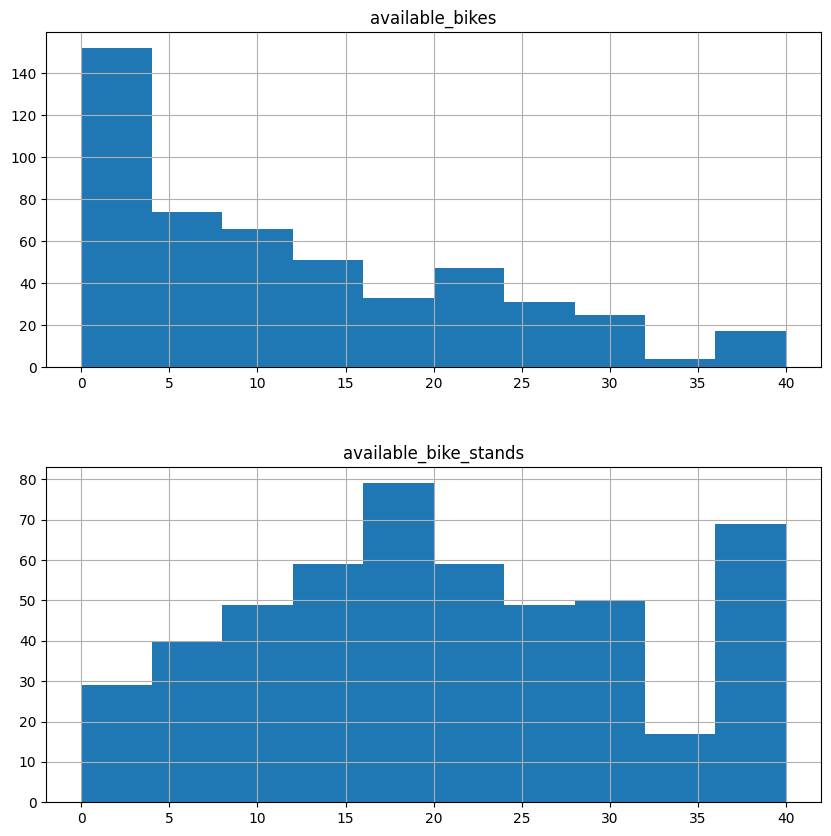

In [162]:
availability_df[continuous_columns].hist(layout=(2, 1), figsize=(10,10), bins=10)

available_bikes             AxesSubplot(0.125,0.11;0.352273x0.77)
available_bike_stands    AxesSubplot(0.547727,0.11;0.352273x0.77)
dtype: object

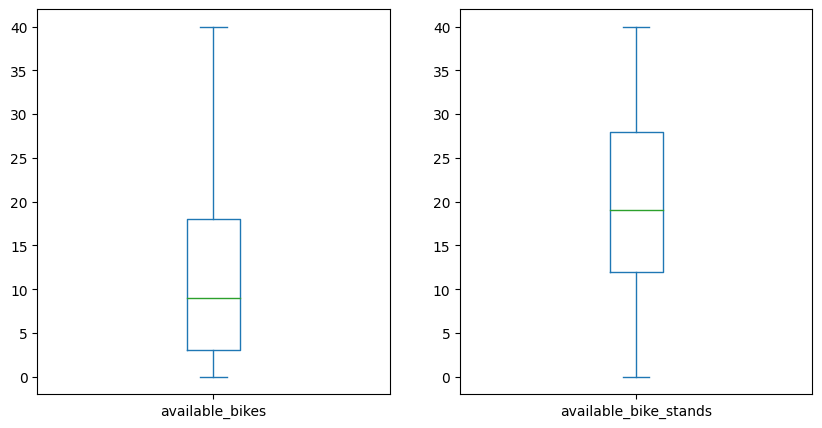

In [164]:
availability_df[continuous_columns].plot(kind='box', subplots=True, figsize=(10,5), layout=(1,2), sharex=False, sharey=False)

<AxesSubplot: >

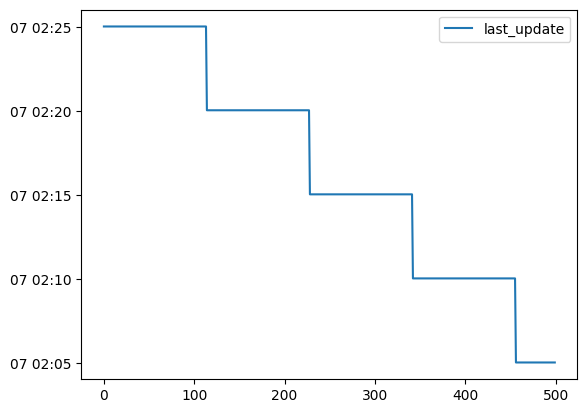

In [165]:
availability_df[datetime_columns].plot()

Index(['last_update'], dtype='object')


array([[<AxesSubplot: title={'center': 'last_update'}>]], dtype=object)

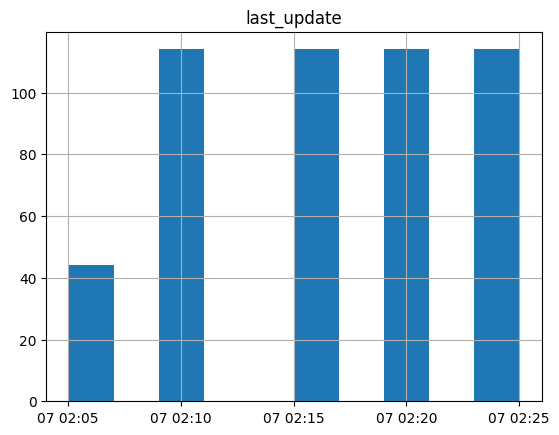

In [169]:
print(datetime_columns)
availability_df[datetime_columns].hist()

Text(0.5, 1.0, 'number')

Text(0, 0.5, 'number of occurances')

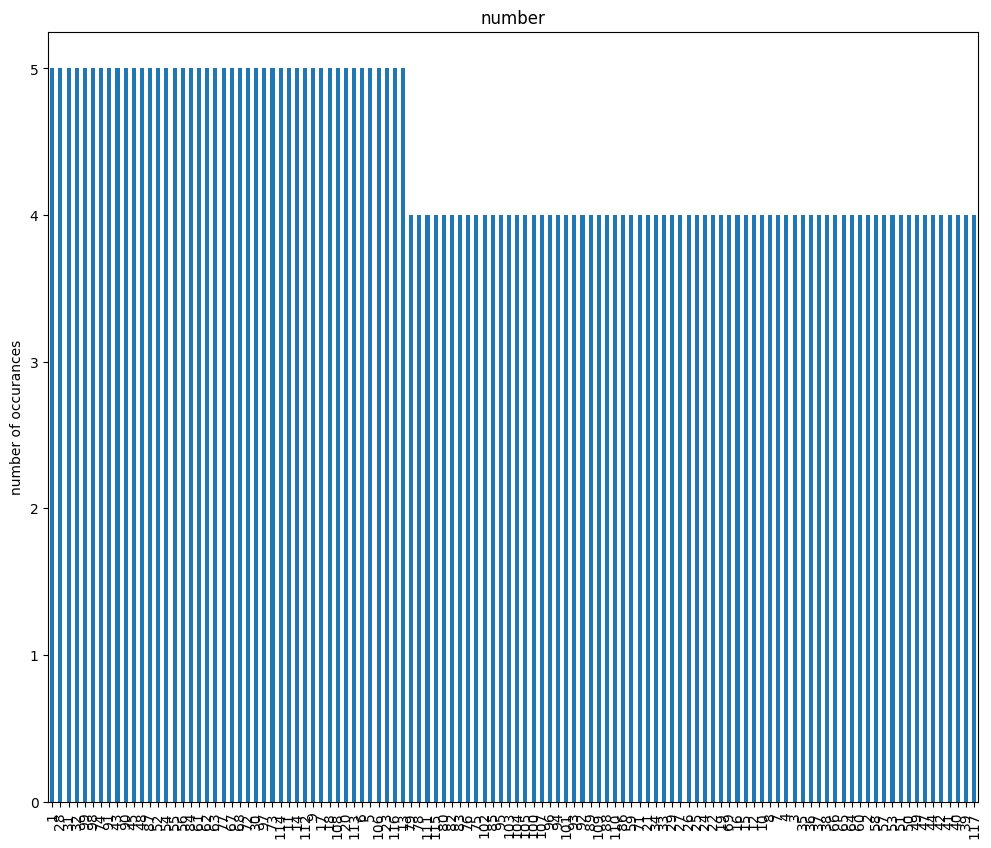

Text(0.5, 1.0, 'status')

Text(0, 0.5, 'number of occurances')

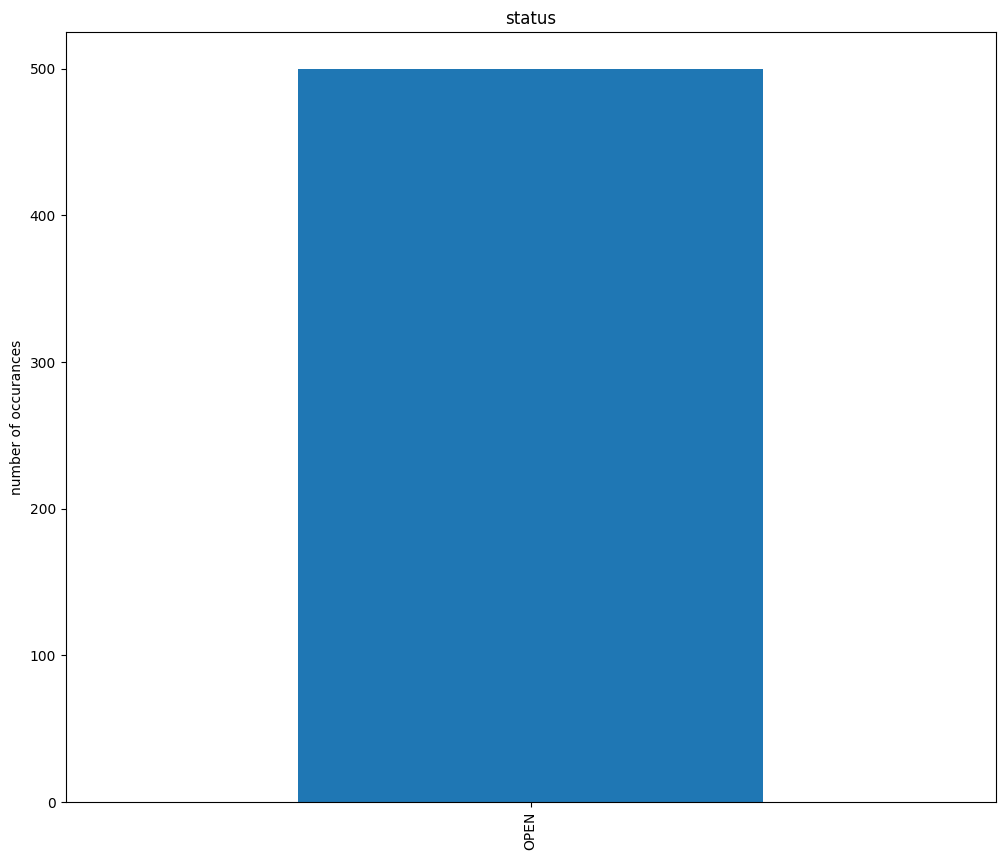

Text(0.5, 1.0, 'entry_id')

Text(0, 0.5, 'number of occurances')

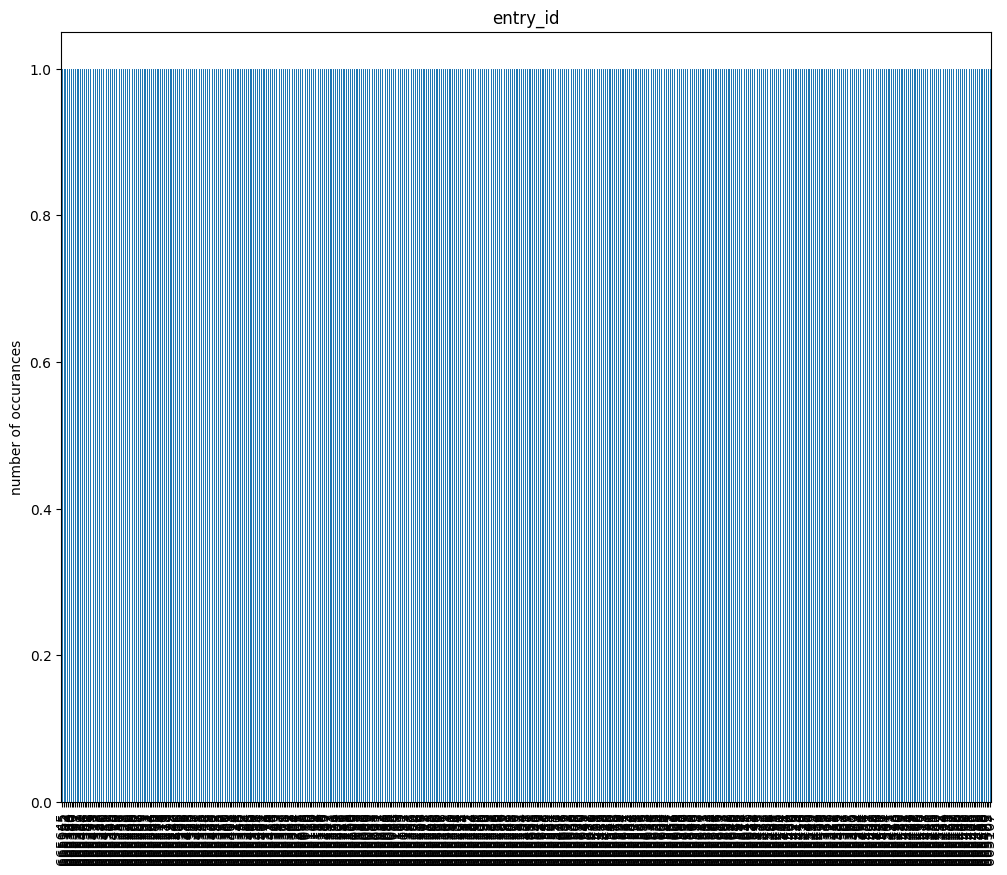

In [170]:
for col in categorical_columns:
    f = df[col].value_counts().plot(kind='bar', figsize=(12,10))
    plt.title(col)
    plt.ylabel('number of occurances')
    plt.show()